In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5,5,0.15)
ys = f(xs)
xs
ys

array([100.    ,  94.9675,  90.07  ,  85.3075,  80.68  ,  76.1875,
        71.83  ,  67.6075,  63.52  ,  59.5675,  55.75  ,  52.0675,
        48.52  ,  45.1075,  41.83  ,  38.6875,  35.68  ,  32.8075,
        30.07  ,  27.4675,  25.    ,  22.6675,  20.47  ,  18.4075,
        16.48  ,  14.6875,  13.03  ,  11.5075,  10.12  ,   8.8675,
         7.75  ,   6.7675,   5.92  ,   5.2075,   4.63  ,   4.1875,
         3.88  ,   3.7075,   3.67  ,   3.7675,   4.    ,   4.3675,
         4.87  ,   5.5075,   6.28  ,   7.1875,   8.23  ,   9.4075,
        10.72  ,  12.1675,  13.75  ,  15.4675,  17.32  ,  19.3075,
        21.43  ,  23.6875,  26.08  ,  28.6075,  31.27  ,  34.0675,
        37.    ,  40.0675,  43.27  ,  46.6075,  50.08  ,  53.6875,
        57.43  ])

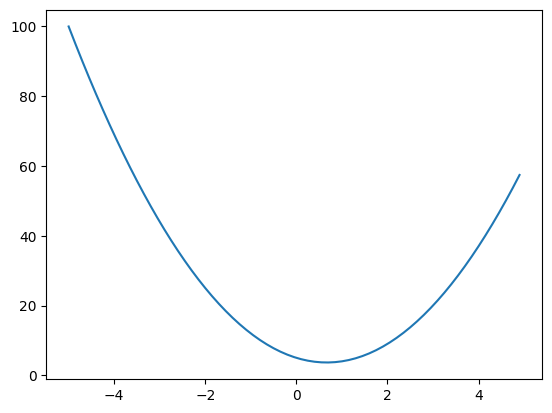

In [5]:
plt.plot(xs, ys)

In [6]:
h = 0.0000000001
x = 3.0
((f(x+h)-f(x))/h)

14.000001158365194

In [7]:
h = 0.0000000001
x = -3.0
((f(x+h)-f(x))/h)

-21.999966293151374

In [8]:
a = 2.0
b = -3.0
c = 10.0
d =a*b +c
print(d)

4.0


In [9]:
h = 0.000000001

#input
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.9999999969999998
slope -3.000000248221113


In [10]:
h = 0.000000001

#input
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.000000002
slope 2.000000165480742


In [11]:
h = 0.000000001

#input
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.000000001
slope 1.000000082740371


In [12]:
import math
from functools import wraps

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad}, op={self._op})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __neg__(self):
        return self * -1

    def __truediv__(self, other):
        return self * (other ** -1)

    def __rtruediv__(self, other):
        return other * (self ** -1)

    def __iadd__(self, other):
        return self + other

    def __imul__(self, other):
        return self * other

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def log(self):
        x = self.data
        out = Value(math.log(x), (self,), 'log')

        def _backward():
            self.grad += (1 / self.data) * out.grad
        out._backward = _backward
        return out

    def sigmoid(self):
        x = self.data
        sig = 1 / (1 + math.exp(-x))
        out = Value(sig, (self,), 'sigmoid')

        def _backward():
            self.grad += sig * (1 - sig) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

    def trace(self):
        def build_trace(v):
            if not hasattr(v, '_trace'):
                v._trace = {'op': v._op, 'data': v.data, 'label': v.label, 'children': []}
                for child in v._prev:
                    v._trace['children'].append(build_trace(child))
            return v._trace

        return build_trace(self)

a = Value(2.0, label = 'a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0, grad=0.0, op=*)

In [13]:
a = Value(2.0)
a + 1

Value(data=3.0, grad=0.0, op=+)

In [14]:
a.exp()

Value(data=7.38905609893065, grad=0.0, op=exp)

In [15]:
from graphviz import Digraph

def trace(root):
    """
    Traces the computational graph from the root node.
    Returns:
        nodes (set): Set of nodes in the graph.
        edges (set): Set of edges in the graph.
    """
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR', node_attrs=None, edge_attrs=None):
    """
    Draws the computational graph using Graphviz.

    Args:
        root (Value): The root node of the computational graph.
        format (str): The output format of the graph. Default is 'svg'.
        rankdir (str): Direction of the graph layout. Default is 'LR'.
        node_attrs (dict): Additional node attributes for customization.
        edge_attrs (dict): Additional edge attributes for customization.

    Returns:
        Digraph: A Graphviz Digraph representing the computational graph.
    """
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})

    nodes, edges = trace(root)

    # Setting default attributes if none provided
    node_attrs = node_attrs or {'shape': 'record'}
    edge_attrs = edge_attrs or {}

    for n in nodes:
        uid = str(id(n))
        label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad)
        dot.node(name=uid, label=label, **node_attrs)

        if n._op and n._op.strip():
            op_id = uid + n._op
            dot.node(name=op_id, label=n._op)
            dot.edge(op_id, uid, **edge_attrs)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op, **edge_attrs)

    return dot


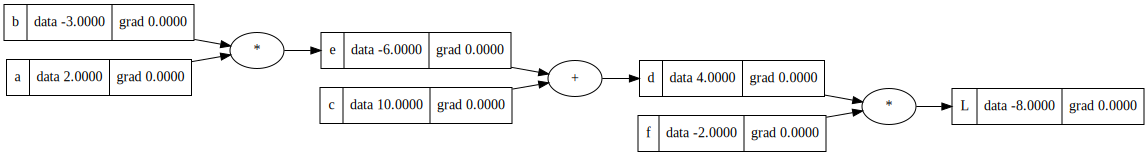

In [16]:
draw_dot(L)

In [17]:
a.grad = 6
b.grad = -4
c.grad = -2
d.grad = -2
e.grad = -2
f.grad = 4
L.grad = 1

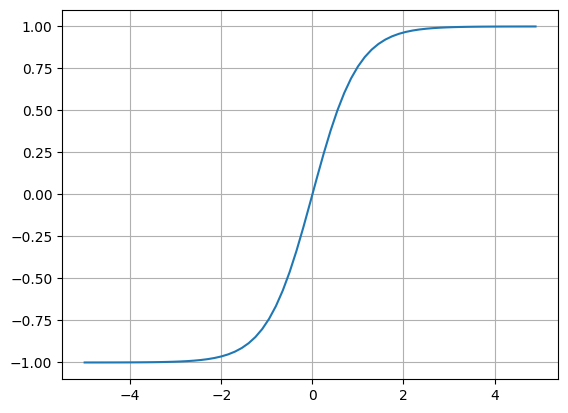

In [18]:
plt.plot(np.arange(-5,5,0.15), np.tanh(np.arange(-5,5,0.15))); plt.grid();

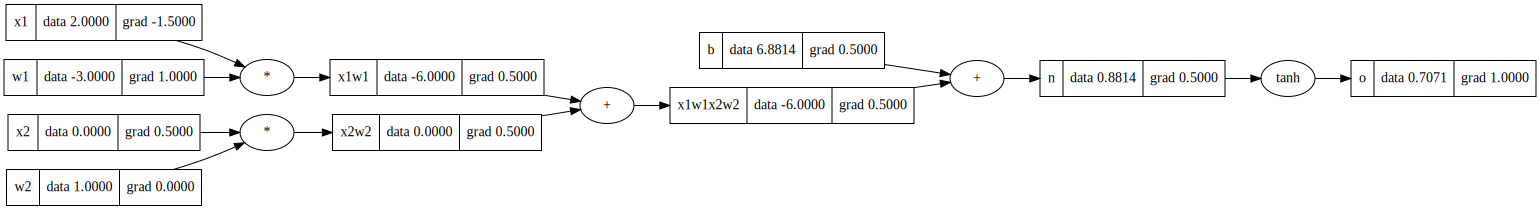

In [19]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, label='b')

# Forward pass
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

# Backward pass
o.backward()

draw_dot(o)


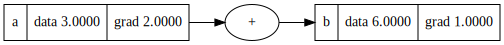

In [20]:
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

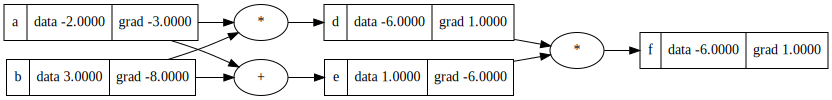

In [21]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a*b; d.label = 'd'
e = a+b; e.label = 'e'
f = d*e; f.label = 'f'
f.backward()
draw_dot(f)

In [22]:
!pip install torch

In [23]:
import torch

torch.tensor([2.0]).double().dtype

torch.float64

In [24]:
x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) #o.item() and o.data.item() does the same thing in pytorch implementations
o.backward()

print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [25]:
x2.grad

tensor([0.5000], dtype=torch.float64)

In [26]:
x2.grad.item()

0.5000001283844369

In [27]:
import math
import random

class Neuron:
    def __init__(self, nin, activation='tanh'):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        self.activation = activation

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        if self.activation == 'tanh':
            out = act.tanh()
        elif self.activation == 'sigmoid':
            out = act.sigmoid()
        elif self.activation == 'relu':
            out = act.relu()
        else:
            out = act  # Linear
        return out

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"Neuron(weights={self.w}, bias={self.b}, activation={self.activation})"

class Layer:
    def __init__(self, nin, nout, activation='tanh'):
        self.neurons = [Neuron(nin, activation) for _ in range(nout)]
        self.activation = activation

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

    def __repr__(self):
        return f"Layer(neurons={self.neurons}, activation={self.activation})"

class MLP:
    def __init__(self, nin, nouts, activation='tanh'):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], activation if i < len(nouts) - 1 else 'linear') for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP(layers={self.layers})"

    def compute_loss(self, predictions, targets):
        # Example loss: Mean Squared Error
        loss = sum((pred - target)**2 for pred, target in zip(predictions, targets)) / len(predictions)
        return loss

    def train(self, x_data, y_data, epochs=100, lr=0.01):
        for epoch in range(epochs):
            total_loss = 0
            for x, y in zip(x_data, y_data):
                predictions = self(x)
                loss = self.compute_loss(predictions, y)
                loss.backward()

                for p in self.parameters():
                    p.data -= lr * p.grad

                total_loss += loss.data

            avg_loss = total_loss / len(x_data)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


In [28]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.006522831608445193, grad=0.0, op=+)

In [29]:
len(n.parameters())

41

In [30]:
xs = [
    [Value(2.0), Value(3.0), Value(-1.0)],
    [Value(3.0), Value(-1.0), Value(0.5)],
    [Value(0.5), Value(1.0), Value(1.0)],
    [Value(1.0), Value(1.0), Value(-1.0)]
]

ys = [Value(1.0), Value(-1.0), Value(-1.0), Value(1.0)]  # desired targets

In [31]:
for k in range(20):
  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygrt)**2 for ygrt, yout in zip(ys, ypred)], Value(0.0))

  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.1 * p.grad #don't try to overfit

  print(k, 'loss', float(loss.data))

0 loss 2.746835825183279
1 loss 0.4079399485288385
2 loss 0.31472397521064793
3 loss 0.23019562921556955
4 loss 0.137952339840208
5 loss 0.08519000643619402
6 loss 0.04690117481848234
7 loss 0.02736877231530348
8 loss 0.01598348154152273
9 loss 0.010001594967850604
10 loss 0.006597883801068908
11 loss 0.00463361940598663
12 loss 0.0034163315634507447
13 loss 0.002615210577969158
14 loss 0.0020551999525591285
15 loss 0.0016429542463247526
16 loss 0.0013285563198492459
17 loss 0.0010820306644054082
18 loss 0.0008855963375195232
19 loss 0.0007271198971622094


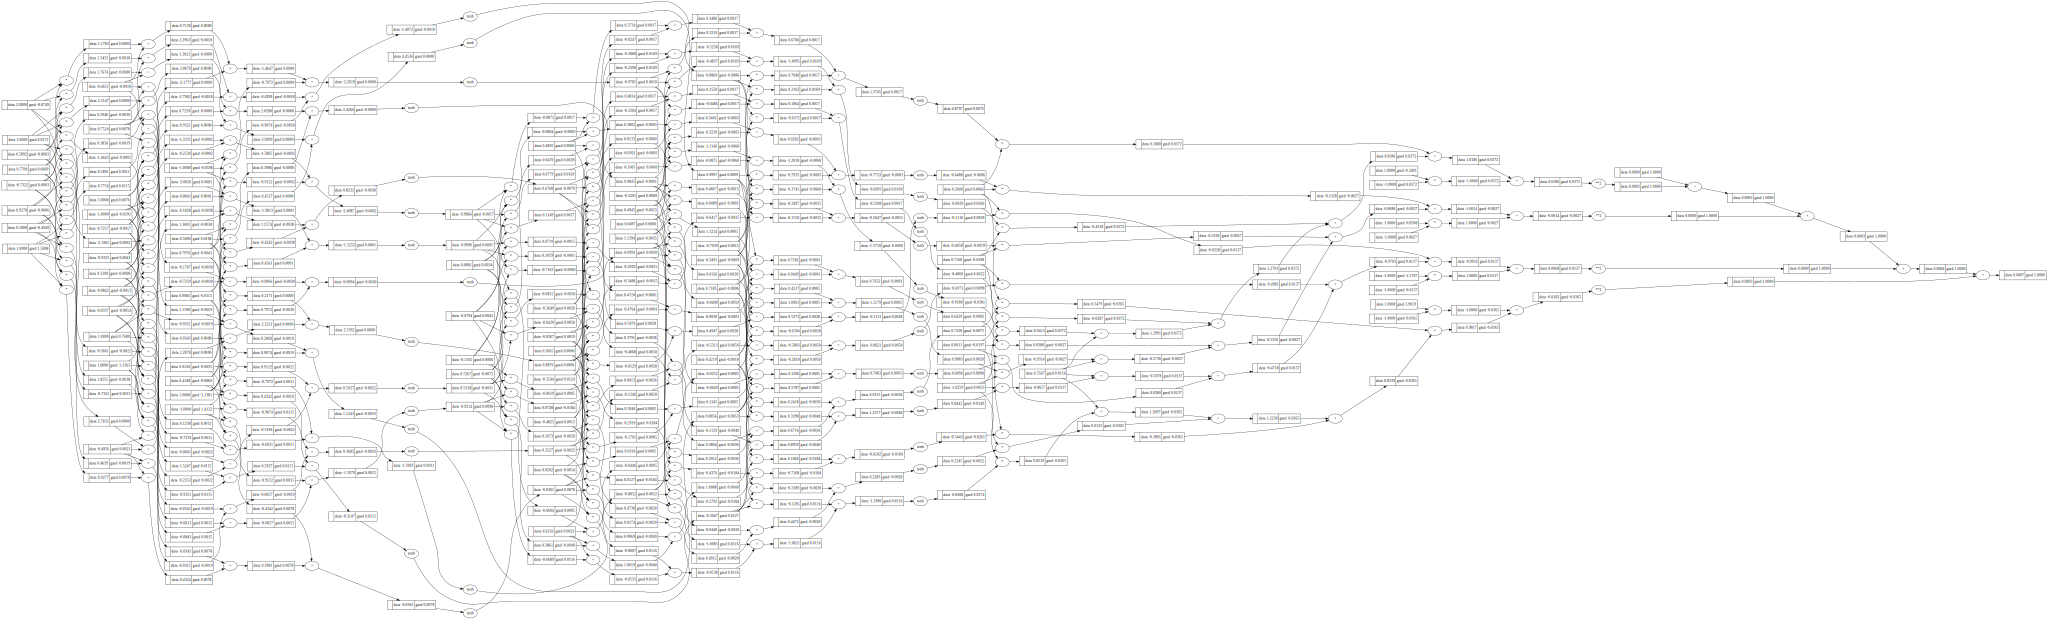

In [32]:
draw_dot(loss)

In [34]:
ypred

[Value(data=1.018587887318488, grad=0.037175774636975856, op=+),
 Value(data=-1.0013605869056437, grad=-0.0027211738112873363, op=+),
 Value(data=-0.9931724050584221, grad=0.013655189883155838, op=+),
 Value(data=0.9817477921120941, grad=-0.03650441577581187, op=+)]